In [1]:
import tensorflow as tf
import os 
import numpy as np
import numpy.random as rng
from tensorflow.examples.tutorials.mnist import input_data
from rbm.examples import bas_data 
from rbm.helper import batch 
from rbm.model import rbm 
import matplotlib.pyplot as plt
import time 

Absolute gradient estimate of log-likelihood on epoch 0 is 0.130719453096
Absolute gradient estimate of log-likelihood on epoch 500 is 0.00138810195494
Absolute gradient estimate of log-likelihood on epoch 1000 is 1.22464316519e-05
Absolute gradient estimate of log-likelihood on epoch 1500 is 5.14685825692e-06
Saving model at: /Users/patricfulop/Documents/Code/Tensorflow/Restricted Boltzman Machine Tensorflow/saved_model/gaussian_RBM_bas8000.ckpt
Elapsed time for training Gaussian RBM with CD-1 and 2000 epochs: 4.542710065841675 


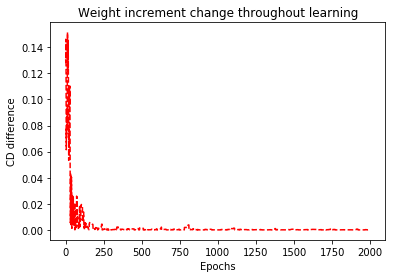

In [2]:
# Create session.
sess = tf.InteractiveSession()

# Initialize RBM Model and batch BAS Dataset
rbm_model= rbm.RBM(n_visible = 16, n_hidden = 16, lr = tf.constant(0.1,tf.float32), epochs = 2000)
data = bas_data.get_data(rng.RandomState(123456))
bt = batch.Batch(X = data, batch_size = 1)

# Placeholder for the visible layer of the RBM computation graph.
v = tf.placeholder(tf.float32, shape=[None,rbm_model.n_visible], name="visible_layer")
size = tf.cast(tf.shape(v)[0], tf.float32)

# Initialize weights and biases for the RBM
with tf.name_scope('Weights'):
    W = tf.Variable(tf.random_normal([rbm_model.n_visible, rbm_model.n_hidden], mean=0., stddev=4 * np.sqrt(6. / (rbm_model.n_visible + rbm_model.n_hidden))), name="weights")
    tf.summary.histogram('weights',W)
    
vb = tf.Variable(tf.zeros([1,rbm_model.n_visible]),tf.float32, name="visible_bias")
hb = tf.Variable(tf.zeros([1,rbm_model.n_hidden]),tf.float32, name="hidden_bias")
error = tf.Variable(tf.zeros([rbm_model.n_visible,rbm_model.n_hidden]),tf.float32, name="error")
err = np.zeros(rbm_model.epochs)

# Similarity between reconstructed/sampled visible layer and input during training. 
# Summary for Tensorboard visualization 
with tf.name_scope("Accuracy"): 
    accuracy = tf.Variable(0.0,name="accuracy")
    tf.summary.scalar('accuracy',accuracy)
    
# K-step Contrastive Divergence using Gibbs sampling
# Positive divergence v_0^T * p(h_0|v_0)
with tf.name_scope('Hidden_probabilities'):
    pos_hid_prob = rbm.get_gaussian_probabilities('hidden',W,v,hb)
with tf.name_scope('Positive_Divergence'):
    pos_divergence = tf.matmul(tf.transpose(v),pos_hid_prob)


pos_hid_states = rbm.sample(pos_hid_prob)
neg_vis_prob = rbm.get_gaussian_probabilities('visible', W, pos_hid_states, vb)

# Negative part v_sampled^T * p(h_sample_k+1|v_sample_k)
with tf.name_scope('Negative_hidden_probabilities'):
    neg_hid_prob = rbm.get_gaussian_probabilities('hidden', W, neg_vis_prob, hb)
with tf.name_scope('Negative_Divergence'):
    neg_divergence = tf.matmul(tf.transpose(neg_vis_prob),neg_hid_prob)
    
    
# Accuracy on reconstructing visible layer 
reconstruction_accuracy = tf.reduce_mean(tf.squared_difference(v,neg_vis_prob))
accuracy_update = [accuracy.assign_add(reconstruction_accuracy)]
    
# Update rules for weights and biases
# Summaries of gradient for Tensorboard visualization
with tf.name_scope('Weight_gradient'):
    delta_w = tf.multiply(rbm_model.lr/size, tf.subtract(pos_divergence,neg_divergence))
    weight_gradient_scalar = tf.summary.scalar('weight_gradient_mean',tf.reduce_mean(delta_w))
with tf.name_scope('Visible_bias_gradient'):
    delta_vb = tf.multiply(rbm_model.lr/size, tf.reduce_sum(tf.subtract(v,neg_vis_prob), 0, keep_dims=True))
with tf.name_scope('Hidden_bias_gradient'):
    delta_hb= tf.multiply(rbm_model.lr/size, tf.reduce_sum(tf.subtract(pos_hid_prob,neg_hid_prob), 0, keep_dims=True))

update = [W.assign_add(delta_w), vb.assign_add(delta_vb), hb.assign_add(delta_hb)] 

# Debug mode
# Weight increment changes as seen by plotting delta_w for the entire dataset
error_sum = [error.assign_add(delta_w)]
total_err = tf.reduce_mean(error)
reinit = error.assign(tf.zeros([rbm_model.n_visible,rbm_model.n_hidden]))

# Merge summaries for Tensorboard
summary = tf.summary.merge_all()
path_test = os.getcwd()  + '/RBM_logs/gaussian_RBM'
test_writer = tf.summary.FileWriter(path_test,sess.graph)

saver = tf.train.Saver({"weights":W, "visible_bias":vb, "hidden_bias":hb})

##### Start of training ######
##### -----------------#######
start_time = time.time()
sess.run(tf.global_variables_initializer())
for epoch in range(rbm_model.epochs):
    if epoch % 30 == 0: 
        sess.run(reinit)
    d = bt.get_batch()
    feed={v: d}
    [error_update, weight_update, accuracy_out, summary_str] = sess.run([error_sum, update, 
                                                                       accuracy_update, summary],feed_dict=feed)
    test_writer.add_summary(summary_str,epoch)
    
    # Print log-likelihood to visualize how it decreases 
    err[epoch] = sess.run(total_err)
    if epoch % 500 == 0 : 
        print("Absolute gradient estimate of log-likelihood on epoch %s is %s" %(epoch,np.abs(err[epoch])))
save_path = saver.save(sess, os.getcwd() + "/saved_model/gaussian_RBM_bas8000.ckpt")
print("Saving model at: %s"%(save_path))
##### --------------- ######        
##### End of Training ######

# Plot
print("Elapsed time for training Gaussian RBM with CD-1 and %s epochs: %s "%(rbm_model.epochs,time.time()-start_time))
rbm.plot_weight_update(x=np.arange(0,rbm_model.epochs,1),y=np.abs(err))

## Test the RBM by trying to reconstruct the visible layer

In [3]:
##### Testing ##### 
# Testing the RBM for one sample step after learning the weights        
test = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0.5, 0, 0, 0, 0]).reshape(1,rbm_model.n_visible)
sample = rbm.gibbs_gaussian(1,v=v,hb=hb,vb=vb,W=W).eval(session=sess, feed_dict={v: test.astype(np.float32)})    
print("Generated sample after %s step is: %s" %(1, sample))

# More debug
out = np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]).reshape(1,rbm_model.n_visible)
print("Sum: %s" %(np.sum((sample - out) ** 2)))


# Some simulations to see how many reconstructed inputs are correct after 1 sampling step. 
# Because i'm not fixing the 0/1 inputs when sampling it's quite unstable, it's stochastic after all. 
# See histogram for why it's a good reconstruction
i = 0
c1 = 0 
r = 300
burnin = r//10
test_input = np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]).reshape(1,rbm_model.n_visible)
test_output = np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]).reshape(1,rbm_model.n_visible)
res = np.zeros([r,rbm_model.n_visible])

for i in range(r+burnin):
    reconstructed_data = rbm.gibbs_gaussian(1,v=v,hb=hb,vb=vb,W=W).eval(session=sess, feed_dict={v: test_input.astype(np.float32)}) 
    if i > burnin:    
        if np.sum((reconstructed_data - test_output) ** 2) <= 0.1:
                   c1 += 1
        res[i-burnin] = reconstructed_data        
    i += 1
print("Ex 1: Reconstructed Data from last step: %s" %(reconstructed_data))
print("Ex 1: Probability for correct state is: %s. Should be close to 1. " %(c1/r))

Generated sample after 1 step is: [[  9.99999642e-01   1.00000000e+00   1.00000000e+00   1.00000000e+00
    4.35958718e-05   1.39083768e-05   2.90391569e-07   7.49068363e-08
    9.97038960e-01   8.25542986e-01   9.75334108e-01   9.29318726e-01
    1.40259537e-04   4.84780503e-05   1.04466753e-05   1.27655903e-05]]
Sum: 0.0360482904607
Ex 1: Reconstructed Data from last step: [[  9.99999523e-01   1.00000000e+00   1.00000000e+00   1.00000000e+00
    3.45642729e-05   5.23462222e-06   2.32387251e-07   3.58863765e-08
    1.00000000e+00   1.00000000e+00   1.00000000e+00   9.99999642e-01
    1.14825583e-04   8.31745911e-06   2.50019730e-06   3.80008237e-06]]
Ex 1: Probability for correct state is: 0.9966666666666667. Should be close to 1. 


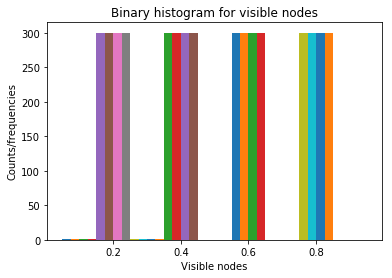

In [4]:
# plt.imshow(res[1:100],interpolation="None",cmap=plt.cm.gray)
plt.hist(res,bins=2)
plt.title('Binary histogram for visible nodes')
plt.xlabel('Visible nodes')
plt.ylabel('Counts/frequencies')
plt.show()